# Fine tuning BERT model for text (relevancy) classification


#### 0) Installation

Make sure your version of Transformers is at least 4.11.0 since the functionality was introduced in that version:

In [2]:
import transformers
print(transformers.__version__)

/opt/homebrew/Caskroom/miniconda/base/envs/opensearch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4.45.1


Import supporting libraries:

In [4]:
import pandas as pd
pd.set_option('max_colwidth', 40)
import torch
import numpy as np
from collections import Counter
from tabulate import tabulate
from tqdm import tqdm_notebook, tqdm
tqdm.pandas()
from sklearn.model_selection import train_test_split

This notebook is built to run with any model checkpoint from the [Model Hub](https://huggingface.co/models) as long as that model has a version with a classification head. Depending on you model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory errors. Set those three parameters, then the rest of the notebook should run smoothly:

In [6]:
model_checkpoint = "allenai/scibert_scivocab_uncased"

#### 1) Loading the dataset

In [7]:
data_path = '../data/' # chemistry datasets

In [8]:
import os
os.listdir('../data/')

['test.csv', 'train.csv']

We import an RCC dataset (training & test splits)

In [9]:
train_org = data_path + '/train.csv'
test_org  = data_path + '/test.csv'

In [10]:
df_train_org = pd.read_csv(train_org, sep=',', low_memory=False)
df_test_org  = pd.read_csv(test_org, sep=',', low_memory=False)

In [11]:
df_train_org.head(3)

,Id,Comment,Topic
0,0x840,A few things. You might have negativ...,Biology
1,0xbf0,Is it so hard to believe that there ...,Physics
2,0x1dfc,There are bees,Biology


In [12]:
df_test_org.head(3)

,Id,Comment,Topic
0,0x1aa9,Personally I have no idea what my IQ...,Biology
1,0x25e,I'm skeptical. A heavier lid would b...,Physics
2,0x1248,I think I have 100 cm of books on th...,Biology


In [13]:
df_train_org.Topic.value_counts(normalize=True)

Topic
Biology      0.412996
Chemistry    0.335825
Physics      0.251179
Name: proportion, dtype: float64

In [14]:
df_test_org.Topic.value_counts(normalize=True)

Topic
Biology      0.387137
Chemistry    0.319042
Physics      0.293821
Name: proportion, dtype: float64

#### 2) Pre-procesing dataset

Tokenization and preprocessing

In [15]:
sample_train_t = df_train_org.head(500)
sample_train_f = df_train_org.tail(500)
sample_train = pd.concat([sample_train_t, sample_train_f])

In [16]:
label_dict = {'Biology':0, 'Chemistry':1, 'Physics':2 }

In [17]:
sample_train['Classes'] = sample_train.Topic.apply(lambda x: label_dict[x])

In [18]:
sample_train.to_csv(data_path + '/sample_train.csv', sep='\t', index=False)

In [19]:
text_train = sample_train.Comment.values
labels_train = sample_train.Classes.values

In [20]:
print(len(sample_train_t))
print(len(sample_train_f))
print(len(sample_train))
print(type(labels_train))
print(type(text_train))

500
500
1000
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [21]:
print(text_train[200], '\t\t',labels_train[200])
print(text_train[210], '\t\t',labels_train[210])
print(text_train[550], '\t\t',labels_train[550])
print(text_train[600], '\t\t',labels_train[600])

There are different viruses that cause colds, and all of those viruses mutate, so even if you have immunity to one, that same one could mutate and express different proteins, or have different modes of infection. \n\nLook at it this way, you could be literally dying of a common cold if you're immune system had zero memory or capability of adapting as quick as it does, so actually its doing a pretty good job. 		 0
They cant be being sold as that can they? 		 1
And when it came out it went drip drip drip 		 0
They kill dogs if they eat them. 		 0


In [22]:
# Check label distribution
Counter(labels_train)

Counter({0: 413, 1: 349, 2: 238})

In [23]:
from transformers import AutoTokenizer 
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

In [24]:
def print_rand_sentence():
    '''
    Displays the tokens and respective IDs of a random text sample
    '''
    index = np.random.randint(0, len(text_train)-1)
    table = np.array([tokenizer.tokenize(text_train[index]), 
                    tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text_train[index]))]).T
    print(tabulate(table,
                 headers = ['Tokens', 'Token IDs'],
                 tablefmt = 'fancy_grid'))

In [25]:
print_rand_sentence()

╒═══════════╤═════════════╕
│ Tokens    │   Token IDs │
╞═══════════╪═════════════╡
│ when      │         603 │
├───────────┼─────────────┤
│ i         │         259 │
├───────────┼─────────────┤
│ watch     │       21075 │
├───────────┼─────────────┤
│ ##ed      │         119 │
├───────────┼─────────────┤
│ the       │         111 │
├───────────┼─────────────┤
│ original  │        2592 │
├───────────┼─────────────┤
│ video     │        4081 │
├───────────┼─────────────┤
│ ,         │         422 │
├───────────┼─────────────┤
│ i         │         259 │
├───────────┼─────────────┤
│ was       │         241 │
├───────────┼─────────────┤
│ like      │        1967 │
├───────────┼─────────────┤
│ well      │         804 │
├───────────┼─────────────┤
│ this      │         238 │
├───────────┼─────────────┤
│ is        │         165 │
├───────────┼─────────────┤
│ cool      │        6240 │
├───────────┼─────────────┤
│ but       │         563 │
├───────────┼─────────────┤
│ why       │       

In [26]:
def preprocessing(input_text, tokenizer):
    '''
    Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    
     - input_ids:      list of token ids
     - token_type_ids: list of token type ids
     - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True)
     
    '''
    return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = 32,
                        truncation=True,
                        padding = 'max_length',
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )

Pre-process dataset

In [27]:
token_id = []
attention_masks = []

# Process
for sample in tqdm(text_train):
    encoding_dict = preprocessing(sample, tokenizer)
    token_id.append(encoding_dict['input_ids']) 
    attention_masks.append(encoding_dict['attention_mask'])

# Store as tensor    
token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels_train)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 8225.50it/s]


In [30]:
token_id[6]

tensor([  102, 13723,   175,   256,   692,  5296,   359,   137,  1461,  1792,
        11302,   103,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

In [31]:
def print_rand_sentence_encoding():
    '''
    Displays tokens, token IDs and attention mask of a random text sample
    '''
    index = np.random.randint(0, len(text_train) - 1)
    tokens = tokenizer.tokenize(tokenizer.decode(token_id[index]))
    token_ids = [i.numpy() for i in token_id[index]]
    attention = [i.numpy() for i in attention_masks[index]]
    table = np.array([tokens, token_ids, attention]).T
    print(tabulate(table, 
                 headers = ['Tokens', 'Token IDs', 'Attention Mask'],
                 tablefmt = 'fancy_grid'))

In [32]:
print_rand_sentence_encoding()

╒═══════════╤═════════════╤══════════════════╕
│ Tokens    │   Token IDs │   Attention Mask │
╞═══════════╪═════════════╪══════════════════╡
│ [CLS]     │         102 │                1 │
├───────────┼─────────────┼──────────────────┤
│ noble     │       28596 │                1 │
├───────────┼─────────────┼──────────────────┤
│ gases     │       15317 │                1 │
├───────────┼─────────────┼──────────────────┤
│ almost    │        3343 │                1 │
├───────────┼─────────────┼──────────────────┤
│ never     │        3449 │                1 │
├───────────┼─────────────┼──────────────────┤
│ react     │        6757 │                1 │
├───────────┼─────────────┼──────────────────┤
│ unless    │        7982 │                1 │
├───────────┼─────────────┼──────────────────┤
│ you       │        3034 │                1 │
├───────────┼─────────────┼──────────────────┤
│ '         │        2505 │                1 │
├───────────┼─────────────┼──────────────────┤
│ re        │

#### 3) Training

Data preparation:

- split into train & validation
- convert to tensors

In [33]:
# 80% for training, 20% for validation
val_ratio = 0.2

# Recommended batch size: 16, 32. 
# See: https://arxiv.org/pdf/1810.04805.pdf
batch_size = 16

# Indices of the train and validation splits stratified by labels
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = val_ratio,
    shuffle = True,
    stratify = labels)

# Train and validation sets
train_set = torch.utils.data.TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

val_set = torch.utils.data.TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])

# Prepare DataLoader
train_dataloader = torch.utils.data.DataLoader(
            train_set,
            sampler = torch.utils.data.RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = torch.utils.data.DataLoader(
            val_set,
            sampler = torch.utils.data.SequentialSampler(val_set),
            batch_size = batch_size
        )

In [34]:
len(train_dataloader)

50

In [35]:
len(validation_dataloader)

13

Performance metrics

In [36]:
def b_tp(preds, labels):
    '''Returns True Positives (TP): count of correct predictions of actual class 1'''
    return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
    '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
    return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
    '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
    return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
    '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
    return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
    '''
    Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
    '''
    preds = np.argmax(preds, axis = 1).flatten()
    labels = labels.flatten()
    tp = b_tp(preds, labels)
    tn = b_tn(preds, labels)
    fp = b_fp(preds, labels)
    fn = b_fn(preds, labels)
    b_accuracy = (tp + tn) / len(labels)
    b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
    b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
    b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
    return b_accuracy, b_precision, b_recall, b_specificity

Get BERT model

In [37]:
from transformers import AutoModelForSequenceClassification

# Load the BertForSequenceClassification model
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels = 3,
    output_attentions = False,
    output_hidden_states = False,
)

# Recommended learning rates (Adam): 5e-5, 3e-5, 2e-5. See: https://arxiv.org/pdf/1810.04805.pdf
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 5e-5,
                              eps = 1e-08
                              )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
# Visualize model statistics
from torchinfo import summary
summary(model, verbose=0)

Layer (type:depth-idx)                                       Param #
BertForSequenceClassification                                --
├─BertModel: 1-1                                             --
│    └─BertEmbeddings: 2-1                                   --
│    │    └─Embedding: 3-1                                   23,877,120
│    │    └─Embedding: 3-2                                   393,216
│    │    └─Embedding: 3-3                                   1,536
│    │    └─LayerNorm: 3-4                                   1,536
│    │    └─Dropout: 3-5                                     --
│    └─BertEncoder: 2-2                                      --
│    │    └─ModuleList: 3-6                                  85,054,464
│    └─BertPooler: 2-3                                       --
│    │    └─Linear: 3-7                                      590,592
│    │    └─Tanh: 3-8                                        --
├─Dropout: 1-2                                               --
├─L

In [40]:
# Set up device
if torch.cuda.is_available():
    torch.device('cuda')
else:
    torch.device('cpu')

In [41]:
# Run on GPU
# model.cuda()

Train model for K epochs:

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Recommended number of epochs: 2, 3, 4. See: https://arxiv.org/pdf/1810.04805.pdf
epochs = 2

for _ in tqdm(range(epochs), desc = 'Epoch'):
    
    # ========== Training ==========
    
    # Set model to training mode
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                             #token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables 
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids, 
                              #token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')

Epoch:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 1/2 [00:21<00:21, 21.47s/it]


	 - Train loss: 0.9965
	 - Validation Accuracy: 0.4760
	 - Validation Precision: 0.4346
	 - Validation Recall: 0.9718
	 - Validation Specificity: 0.2122



Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:43<00:00, 21.64s/it]


	 - Train loss: 0.6756
	 - Validation Accuracy: 0.5625
	 - Validation Precision: 0.7064
	 - Validation Recall: 0.4702
	 - Validation Specificity: 0.8158



#### 4) Inference

Predict if context is relevant:

In [43]:
new_sentence = df_test_org.Comment.values[100]
new_label = df_test_org.Topic.apply(lambda x: label_dict).values[100]

# We need Token IDs and Attention Mask for inference on the new sentence
test_ids = []
test_attention_mask = []

# Apply the tokenizer
encoding = preprocessing(new_sentence, tokenizer)

# Extract IDs and Attention Mask
test_ids.append(encoding['input_ids'])
test_attention_mask.append(encoding['attention_mask'])
test_ids = torch.cat(test_ids, dim = 0)
test_attention_mask = torch.cat(test_attention_mask, dim = 0)

# Forward pass, calculate logit predictions
with torch.no_grad():
    output = model(test_ids.to(device), attention_mask = test_attention_mask.to(device))

# Prediction format
# 1: chemistry
# 0: biology
# 2: physics
prediction = np.argmax(output.logits.cpu().numpy()).flatten().item()

print('Input  Sentence:\t', new_sentence)
print('Input     Class:\t', new_label)
print('Predicted Class:\t', prediction)

Input  Sentence:	 Hmm, im not sure! I can’t find any parrots that look like that : (\n\nBirds are usually hard to gender unless they have physical differences, vets have to do a blood dna test to find out
Input     Class:	 {'Biology': 0, 'Chemistry': 1, 'Physics': 2}
Predicted Class:	 0


In [44]:
new_sentence = df_test_org.Comment.values[12]
new_label = df_test_org.Topic.apply(lambda x: label_dict).values[12]

# We need Token IDs and Attention Mask for inference on the new sentence
test_ids = []
test_attention_mask = []

# Apply the tokenizer
encoding = preprocessing(new_sentence, tokenizer)

# Extract IDs and Attention Mask
test_ids.append(encoding['input_ids'])
test_attention_mask.append(encoding['attention_mask'])
test_ids = torch.cat(test_ids, dim = 0)
test_attention_mask = torch.cat(test_attention_mask, dim = 0)

# Forward pass, calculate logit predictions
with torch.no_grad():
    output = model(test_ids.to(device), attention_mask = test_attention_mask.to(device))

# Prediction format
# 1: chemistry
# 0: biology
# 2: physics
prediction = np.argmax(output.logits.cpu().numpy()).flatten().item()

print('Input  Sentence:\t', new_sentence)
print('Input     Class:\t', new_label)
print('Predicted Class:\t', prediction)

Input  Sentence:	 MOND has a problem for pretty much any galaxy cluster, there is a mass deficit. The higher the mass the larger the discrepancy, El Gordo is just the largest. But you can still wave your hands and say some baryons have been missed, or there is some second order effect. The Bullet Cluster presents a different problem. There most of the baryonic matter has been stripped out of the cluster centres, but the lensing is still centred on the cluster cores.
Input     Class:	 {'Biology': 0, 'Chemistry': 1, 'Physics': 2}
Predicted Class:	 0


#### 5) Save model and tokenizer

In [ ]:
!mkdir ../model
!mkdir ../model/classif
!mkdir ../model/tokenizer

In [45]:
model.save_pretrained('../model/classif')

In [ ]:
tokenizer.save_pretrained('../model/tokenizer')

#### 6) Performance statistics

In [46]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score
import matplotlib.pyplot as plt
from datetime import date

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Matplotlib is building the f

Helper functions

In [47]:
def model_inference(in_model, in_tokenizer, in_sentence):
    '''
    Apply model `model` to input sentence `s`
    '''
    # We need Token IDs and Attention Mask for inference on the new sentence
    test_ids = []
    test_attention_mask = []
    # Apply the tokenizer
    encoding = preprocessing(in_sentence, in_tokenizer)
    # Extract IDs and Attention Mask
    test_ids.append(encoding['input_ids'])
    test_attention_mask.append(encoding['attention_mask'])
    test_ids = torch.cat(test_ids, dim = 0)
    test_attention_mask = torch.cat(test_attention_mask, dim = 0)
    # Forward pass, calculate logit predictions
    with torch.no_grad():
        output = in_model(test_ids.to(device), attention_mask = test_attention_mask.to(device))
    # Predictions and probabilities
    prob = torch.softmax(output.logits.cpu()[0],-1).numpy()[1]
    prediction = np.argmax(output.logits.cpu().numpy()).flatten().item()
    #print (prob, prediction)
    return prob, prediction

In [48]:
def plot_prec_recall_curve(df, save = False):
    '''
    Plot precision-recall curves
    '''
    precisions, recalls, thresholds = precision_recall_curve(df['Chemical'].values, 
                                                             df['Probability'].values,
                                                             pos_label=1)
    f1s = (2 * precisions * recalls) / (precisions + recalls)
    plt.figure(1)
    plt.title("Precision-Recall Curve")
    plt.plot(thresholds, precisions[0:-1], 'b', label='Precision')
    plt.plot(thresholds, recalls[0:-1], 'g', label='Recall')
    plt.plot(thresholds, f1s[0:-1], 'r', label='F1-score')
    plt.xlabel('Confidence Score')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    today = date.today()
    if save:
        plt.savefig(data_path + '/prec_recall_curve_'+str(today)+'.png',bbox_inches='tight')

In [49]:
def model_inference_evaluation(mod_df, save_plot = False):
    '''
    Evaluate model on dataframe
    '''
    df_test_dd = mod_df[['Id', 'Topic','Probability','Chemical']].copy()
    df_test_dd = df_test_dd.drop_duplicates()   
    # Generate evaluation stats
    print(classification_report(mod_df['Chemical'], mod_df['Prediction']))
    print('ROC Score:', roc_auc_score(mod_df['Chemical'], mod_df['Prediction']))
    print('F1 Score:', f1_score(mod_df['Chemical'], mod_df['Prediction']))
    plot_prec_recall_curve(mod_df, save_plot)

Evaluate on test set

The model takes ~10s per instance on CPU

In [50]:
df_test_org_x = df_test_org.head(2000)
df_test_org_x.Topic.value_counts(normalize=True)

Topic
Biology      0.387137
Chemistry    0.319042
Physics      0.293821
Name: proportion, dtype: float64

In [51]:
df_test_org_x.to_csv(data_path + '/sample_test_raw.csv', sep='\t', index=False)

In [52]:
preds = df_test_org_x.Comment.progress_apply(lambda s: model_inference(model, tokenizer, s))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1586/1586 [00:24<00:00, 65.51it/s]


In [53]:
preds.head(3)

0    (0.29777467, 0)
1    (0.39540517, 1)
2     (0.0882736, 0)
Name: Comment, dtype: object

In [54]:
import warnings
warnings.filterwarnings('ignore')

def rel(x):
    if x == 1:
        return x
    else:
        return 0

df_test_org_x['Chemical'] = df_test_org_x.Topic.apply(lambda x: label_dict[x]).apply(lambda x: rel(x))
df_test_org_x['Prediction'] = preds.apply(lambda x: x[1]).apply(lambda x: rel(x))
df_test_org_x['Probability'] = preds.apply(lambda x: x[0])

from pandas import option_context
with option_context('display.max_colwidth', 100):
    display(df_test_org_x[['Comment', 'Probability', 'Chemical', 'Prediction']][df_test_org_x.Chemical==1].head(3))
    display(df_test_org_x[['Comment', 'Probability', 'Chemical', 'Prediction']][df_test_org_x.Chemical==0].head(3))

,Comment,Probability,Chemical,Prediction
3,Is chemistry hard in uni. Ive read somewhere that its the hardest degree. But ive really been en...,0.889229,1,1
5,It's probably my perspective too because I lived in London (250+ ppm) where it's way harder than...,0.397971,1,0
10,"Essentially, it is the change in volume between the transition state and the reactants. Formally...",0.772051,1,1


,Comment,Probability,Chemical,Prediction
0,"Personally I have no idea what my IQ is. I’ve never been tested. However, the test is an outdate...",0.297775,0,0
1,"I'm skeptical. A heavier lid would be needed to build pressure, while a lighter lid is needed to...",0.395405,0,1
2,I think I have 100 cm of books on the subject. TL;DR: The problem of consciousness is universall...,0.088274,0,0


              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1080
           1       0.70      0.70      0.70       506

    accuracy                           0.81      1586
   macro avg       0.78      0.78      0.78      1586
weighted avg       0.81      0.81      0.81      1586

ROC Score: 0.7779186795491142
F1 Score: 0.6977205153617443


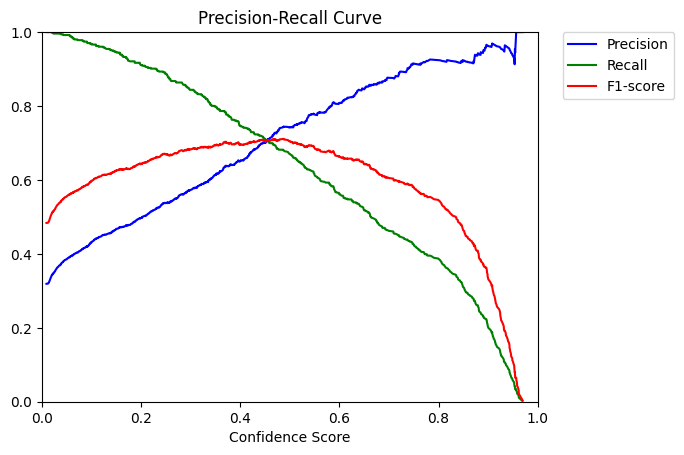

In [55]:
model_inference_evaluation(df_test_org_x)

In [57]:
df_test_org_x.to_csv(data_path + '/sample_test_labelled.csv', sep='\t', index=False)